In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import os
import math
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors


name =  '2025_02_06_15_05_110SAC' # '2025_01_22_22_53_000SAC'   '2024_11_04_16_24_37' #'2024_06_11_15_11_25' 
env_name = 'myoTorsoReachFixed-v1'
steps = 700
cut = 100

pkl_path = './output/PKL/' + env_name + '/'
ep = 100


def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

image_path = './image/' + env_name + '/' + name
os.makedirs(image_path, exist_ok=True)

bins = [0, 10, 20, 30, 40]
stand, stand_80, stand_60, stand_40 = [], [], [], []

In [2]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Function to determine the interval label
def find_interval_label(value, intervals, labels):
    for (low, high), label in zip(intervals, labels):
        if low <= value <= high:
            return label
    return None

# Main function to process data
def process_data(directory, base_filename, num_episodes, intervals, interval_labels):
    interval_data = {label: [] for label in interval_labels}
    
    # Iterate over each file based on episode count
    for i in range(num_episodes):
        file_path = os.path.join(directory, f'{base_filename}_{i}.pkl')
        if os.path.exists(file_path):
            data = load_pickle(file_path)
            if data['bodyInfo']['height'][-1] > 0.0:
                p_t = int(data['modelInfo']['perturbationTime'] * 100)
                acceleration = max(abs(arr[0]) for arr in data['jointInfo']['qacc']['slide_joint'][p_t: p_t + 20])
                trunk_angles = data['jointInfo']['qpos']['flex_extension'][p_t: p_t + 400]  # Assuming this is a list of joint angles over time
                COM_change = [np.append(sublist, data['bodyInfo']['height'][j]) for j, sublist in enumerate(data['bodyInfo']['com'][p_t: p_t + 400])]

                label = find_interval_label(acceleration, intervals, interval_labels)
                if label:
                    # Append the joint angles and COM changes as a DataFrame
                    df = pd.DataFrame({'Time': range(len(trunk_angles)), 'Trunk': trunk_angles, 'COM': COM_change})
                    interval_data[label].append(df)

    # Average the data for each interval and maintain as a function of time
    interval_averages = {}
    for label in interval_labels:
        if interval_data[label]:
            combined_df = pd.concat(interval_data[label])
            average_df = combined_df.groupby('Time').mean().reset_index()
            interval_averages[label] = average_df

    # Combine all interval DataFrames into one
    if interval_averages:
        combined_df = pd.concat(interval_averages, names=['Interval', 'Time'])
        return combined_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data was processed


num_episodes = 100  # Number of episodes/files to process
intervals = [(0, 10), (11, 20), (21, 30), (31, 40)]
interval_labels = ['10', '20', '30', '40']
healthy_df = process_data(pkl_path, name, num_episodes, intervals, interval_labels)
print(healthy_df)

               Time                   Trunk  \
Interval Time                                 
10       0        0   [-0.3140210867500437]   
         1        1  [-0.31403264379165857]   
         2        2   [-0.3137456661284166]   
         3        3  [-0.31319139189368916]   
         4        4   [-0.3125973603856971]   
...             ...                     ...   
40       395    395   [-0.3118348540203102]   
         396    396  [-0.31182731249639084]   
         397    397   [-0.3118188804626419]   
         398    398   [-0.3118096987180724]   
         399    399  [-0.31179981650782657]   

                                                             COM  
Interval Time                                                     
10       0     [0.012773639133777652, -0.00010726933373104778...  
         1     [0.013239081587476413, -0.0001054646575981467,...  
         2     [0.014126479671180798, -0.00010627876549893207...  
         3     [0.015140190022739072, -0.000110014187

In [3]:
print(healthy_df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1600 entries, ('10', 0) to ('40', 399)
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Time    1600 non-null   int64 
 1   Trunk   1600 non-null   object
 2   COM     1600 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.6+ KB
None


In [4]:
name = '2025_02_10_13_44_020SAC'#'2024_11_04_16_24_37' #'2024_06_11_15_11_25' 
env_name = 'myoSarcTorsoReachFixed-v1'
pkl_path = './output/PKL/' + env_name + '/'
sarc80_df = process_data(pkl_path, name, num_episodes, intervals, interval_labels)
#print(sarc80_df)


In [5]:
name = '2025_02_12_14_12_560SAC'#'2025_02_11_09_54_530SAC'#'2024_11_04_16_24_37' #'2024_06_11_15_11_25' 
env_name = 'myoSarcTorsoReachFixed-v1'

pkl_path = './output/PKL/' + env_name + '/'
sarc60_df = process_data(pkl_path, name, num_episodes, intervals, interval_labels)
#print(sarc60_df)

In [6]:
name = '2025_02_12_00_04_090SAC'#'2024_11_04_16_24_37' #'2024_06_11_15_11_25' 
env_name = 'myoSarcTorsoReachFixed-v1'
pkl_path = './output/PKL/' + env_name + '/'
sarc40_df = process_data(pkl_path, name, num_episodes, intervals, interval_labels)
#print(sarc40_df)

In [7]:
df_combined = pd.concat([healthy_df, sarc80_df, sarc60_df, sarc40_df], 
                        keys=['Healthy', '80%', '60%', '40%'],
                        names=['Group', 'Interval', 'Index'])

df_combined.reset_index(inplace=True)

df_lists = df_combined.groupby(['Interval', 'Group'])['Trunk'].apply(list).unstack()

df_COM_lists = df_combined.groupby(['Interval', 'Group'])['COM'].apply(list).unstack()


# Example output
print(df_COM_lists)


Group                                                   40%  \
Interval                                                      
10        [[0.021862233377695568, -0.005552048904172637,...   
20        [[0.019971417104150197, -0.006950144871592125,...   
30        [[0.01916859485641712, -0.005341190024562244, ...   
40        [[0.017159595638463348, -0.008235214793480638,...   

Group                                                   60%  \
Interval                                                      
10        [[0.03430983991368502, 0.0038599824703055546, ...   
20        [[0.03444145002535108, 0.003732186233513931, 0...   
30        [[0.03479598776193477, 0.00378980975254665, 0....   
40        [[0.03494883130122678, 0.003320736097297171, 0...   

Group                                                   80%  \
Interval                                                      
10        [[0.025225399149111514, 0.003115493974972072, ...   
20        [[0.02527770688130283, 0.003272477796768472

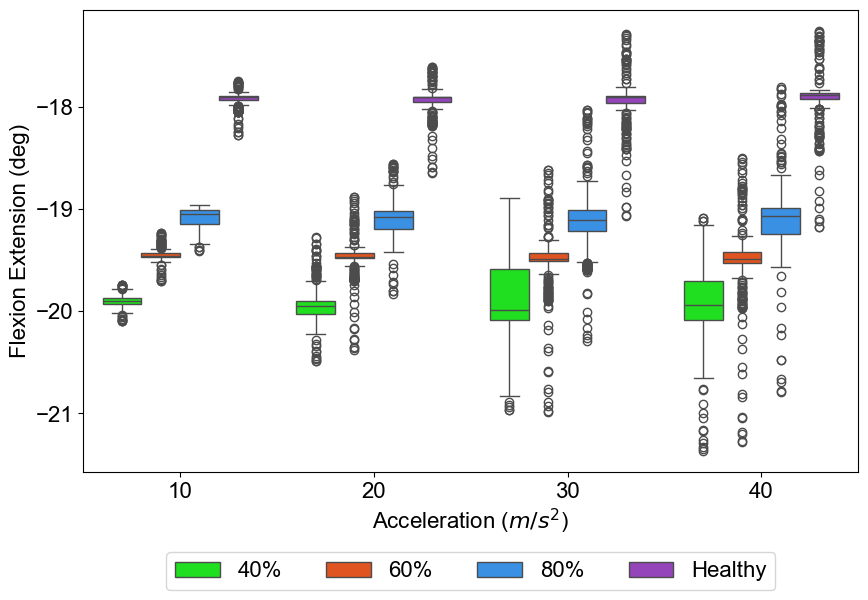

In [8]:
import seaborn as sns

def flatten(df):
    flat_data = []
    for col in df.columns:
        for idx, values in df[col].items():
            for value in values:
                flat_data.append({'Interval': idx, 'Group': col, 'Value': value[0]*180/np.pi})
    return flat_data

def flatten_COM(df):
    flat_data = []
    for col in df.columns:
        for idx, values in df[col].items():
            for value in values:
                flat_data.append({'Interval': idx, 'Group': col, 'Value': np.linalg.norm(value)*100 - 60})
    return flat_data

flat_df_trunk = pd.DataFrame(flatten(df_lists))
flat_df_COM = pd.DataFrame(flatten_COM(df_COM_lists))

custom_palette = ['lime', 'orangered', 'dodgerblue', 'darkorchid']

font = {'family': 'Arial',
        'weight': 'normal',
        'size': 16}

# Apply font properties
matplotlib.rc('font', **font)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Interval', y='Value', hue='Group', data=flat_df_trunk, palette=custom_palette)
#plt.title('Boxplot of Values by Interval for Each Group')
plt.xlabel(r'Acceleration ($m/s^2$)')
plt.ylabel('Flexion Extension (deg)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

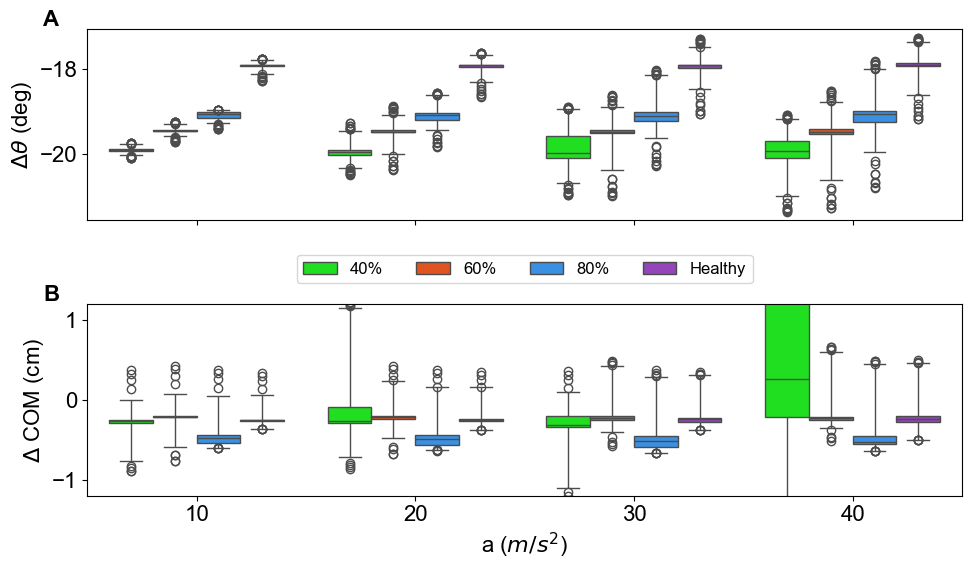

In [14]:
import matplotlib.patches as mpatches
custom_palette = ['lime', 'orangered', 'dodgerblue', 'darkorchid']

# Define font properties
font = {'family': 'Arial',
        'weight': 'normal',
        'size': 16}

# Apply font properties
matplotlib.rc('font', **font)

# Create a figure with two subplots (vertically arranged)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# Plot for flat_df_trunk
sns.boxplot(x='Interval', y='Value', hue='Group', data=flat_df_trunk, whis=(2, 98),  palette=custom_palette, ax=axes[0])
#axes[0].set_title('A: Trunk')
axes[0].set_xlabel('')  # Remove x label for the top plot
axes[0].set_ylabel(r'$\Delta$$\theta$ (deg)')
axes[0].text(-0.05, 1.1, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# Adding legend to the first plot
axes[0].legend_.remove()


colors = ['dodgerblue', 'orangered', 'lime', 'darkorchid']
labels = ['80%', '60%', '40%', 'Healthy']

# Create a list of patches to add to the legend
patches = [mpatches.Patch(facecolor=color, edgecolor= 'black', label=label) for color, label in zip(colors, labels)]


# Plot for flat_df_COM
sns.boxplot(x='Interval', y='Value', hue='Group', data=flat_df_COM, whis=(1, 99), palette=custom_palette, ax=axes[1])
#axes[1].set_title('B: Center of Mass')
axes[1].set_xlabel(r'a ($m/s^2$)')
axes[1].set_ylabel(r'$\Delta$ COM (cm)')
axes[1].text(-0.05, 1.1, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
axes[1].set_ylim([-1.2, 1.2])
# Adding legend to the second plot
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=4, fontsize = 12)

# Adjust layout to prevent overlap and ensure everything fits
plt.tight_layout()
plt.show()